# Importing required Libraries

In [1]:
!pip install ipython-autotime
!pip install --upgrade transformers
%matplotlib inline
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=bcc050576f1f58e04d6ebe31eb4cd4bfbdfca57779ee964b282aeaa8c180f1bf
  Stored in directory: /root/.cache/pip/wheels/28/3a/38/7ecc013df8b58518cf859fb86c67c53df318426e96bb9fe1c0
Successfully built ipython-autotime
     |████████████████████████████████| 641 kB 3.5 MB/s 
     |████████████████████████████████| 3.8 MB 21.1 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.5.2
    Uninstalling tokenizers-0.5.2:
      Successfully uninstalled tokenizers-0.5.2
  Attempting uninstall: transformers
    Found existing installation: transformers 2.7.0
    Uninstalling transformers-2.7.0:
      Successfully uninstalled transformers-2.7.0


In [2]:
import os,re
import unicodedata
import gc
import time
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy

import transformers
from transformers import TFAutoModel, AutoTokenizer
from transformers import T5Tokenizer, TFT5Model
from transformers import TFElectraModel, ElectraTokenizerFast
from tokenizers import BertWordPieceTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

from tqdm.notebook import tqdm
from numba import jit, cuda 

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


time: 11.8 s


# TPU Configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
time: 3.3 s


# Reading Data

In [4]:
# the data paths
data_path = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
translated_data_path = '/kaggle/input/jigsaw-multilingual-toxic-test-translated/'

# loading all the train datasets

train_data1 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
# train_data2 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')
train_data3 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
# train_data4 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train-processed-seqlen128.csv')

# loading all the validation and test datasets

# validation_data1 = pd.read_csv(data_path + 'validation.csv')
# validation_data2 = pd.read_csv(data_path + 'validation-processed-seqlen128.csv')
valid_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_valid_translated.csv')

# test_data1 = pd.read_csv(data_path + 'test.csv')
# test_data2 = pd.read_csv(data_path + 'test-processed-seqlen128.csv')
test_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_test_translated.csv')

time: 20.8 s


# Exploratory Data Analysis

*Link to the notebook:*


# Helper Functions

Data cleaning Functions

In [5]:
# Stopword list
pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# @tf.function()
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    
    #replacing email addresses with blank space
    text = re.sub(r"[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5}"," ",text)
    
    #replacing urls with blank space
    text = re.sub(r"\bhttp:\/\/([^\/]*)\/([^\s]*)|https:\/\/([^\/]*)\/([^\s]*)"," ",text)
    
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    # replacing all the stopwords
    text = pattern.sub('',text)
    
    # removes all the punctuations
    text = re.sub(r"[^a-zA-Z]+", " ", text)
    
    text = text.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
#     text = '<start> ' + text + ' <end>'
    
    return text

clean_text_vect = np.vectorize(clean_text)

time: 19.2 ms


In [6]:
def fast_clean(array,chunk_size=256):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = clean_text_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

time: 1.49 ms


Tokenizing and Encoding Functions

In [7]:
def regular_encode(texts, tokenizer, maxlen=512):
    tokenizer.pad_token = tokenizer.pad_token
    tokenizer.unk_token = tokenizer.unk_token
    
    enc_di = tokenizer.batch_encode_plus(
        list(texts), 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        add_special_tokens=True
    )
    
    return np.array(enc_di['input_ids'])

time: 1.61 ms


In [8]:
def chunk_encode(texts,tokenizer,maxlen=512,chunk_size=256):
    all_enc=[]
    for i in tqdm(range(0,len(texts),chunk_size)):
        enc = list(regular_encode(texts[i:i+chunk_size],tokenizer,maxlen=maxlen))
        all_enc.extend(enc)
        
    return np.array(all_enc)

time: 1.65 ms


In [9]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

time: 2.44 ms


# Defining the Tokenizer

Pre-trained models

In [10]:
MODEL = 'google/electra-large-generator'
MODEL2 = 'google/electra-large-discriminator'
MODEL3 = 'gpt2-medium'

time: 684 µs


Initializing the Tokenizers

In [11]:
tokenizer = ElectraTokenizerFast.from_pretrained(MODEL)
print(tokenizer.save_pretrained('.'))
print(tokenizer)


('./vocab.txt', './special_tokens_map.json', './added_tokens.json')
time: 945 ms


In [12]:
# bert_tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-large-uncased')
# bert_tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('./vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)

time: 30.7 ms



# Data Preparation

Data splitting

In [13]:
train_data3.toxic = train_data3.toxic.round().astype(int)
valid_translated['comment_text'] = valid_translated['translated']

data = pd.concat([
    train_data1[['comment_text', 'toxic']],
    train_data3[['comment_text', 'toxic']].query('toxic==1'),
    train_data3[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0),
    valid_translated[['comment_text','toxic']]
])
data.toxic = data.toxic.round().astype(int)
data.drop_duplicates(inplace=True)

final_test_data = test_translated.translated.values

print('Number of toxic comments = ',list(data.toxic).count(1))
print('Number of non-toxic comments = ',list(data.toxic).count(0))

Number of toxic comments =  133439
Number of non-toxic comments =  358271
time: 2.14 s


In [14]:
np.random.seed(2048)
train, valid, test = np.split(data.sample(frac=1), [int(.98*len(data)), int(.99*len(data))])

print("Train rows = ", train.shape[0])
print("validate rows = ", valid.shape[0])
print("Test rows = ", test.shape[0])
print("\nFinal Test Data rows = ",len(final_test_data))

Train rows =  481875
validate rows =  4917
Test rows =  4918

Final Test Data rows =  63812
time: 151 ms


In [15]:
del train_data1
del train_data3
del valid_translated
del data
gc.collect()

499

time: 411 ms


Cleaning & Tokenizing Input data and Preparing Labels

In [16]:
MAX_LEN = 128

time: 1.95 ms


In [17]:
x_train = fast_clean(train.comment_text.values)
x_valid = fast_clean(valid.comment_text.values)
x_test = fast_clean(test.comment_text.values)

final_test_data = fast_clean(final_test_data)


time: 3min 55s


In [18]:
# x_train = chunk_encode(x_train, tokenizer, maxlen=MAX_LEN)
# x_valid = chunk_encode(x_valid, tokenizer, maxlen=MAX_LEN)
# x_test = chunk_encode(x_test, tokenizer, maxlen=MAX_LEN)

# final_test_data = chunk_encode(final_test_data, tokenizer, maxlen=MAX_LEN)

time: 437 µs


In [19]:
x_train = fast_encode(x_train, fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(x_valid, fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(x_test, fast_tokenizer, maxlen=MAX_LEN)

final_test_data = fast_encode(final_test_data, fast_tokenizer, maxlen=MAX_LEN)


time: 1min 10s


In [20]:
y_train = np.array(train.toxic.values)
y_train.resize((len(y_train),1))

y_valid = np.array(valid.toxic.values)
y_valid.resize((len(y_valid),1))

y_test = np.array(test.toxic.values)
y_test.resize((len(y_test),1))

time: 3.59 ms


In [21]:
print('New shape of comments and labels after TOKENIZATION and PROCESSING:-')
print('-'*50)
print('Data for Training and Evaluation:\n')
print('x_train shape = ',x_train.shape)
print('x_valid shape = ',x_valid.shape)
print('x_test shape = ',x_test.shape)
print('-'*30)
print('Labels shapes:\n')
print('y_train shape = ',y_train.shape)
print('y_valid shape = ',y_valid.shape)
print('y_test shape = ',y_test.shape)
print('-'*50)
print('The Final data for Predication:\n')
print('final_test_data shape = ',final_test_data.shape)

New shape of comments and labels after TOKENIZATION and PROCESSING:-
--------------------------------------------------
Data for Training and Evaluation:

x_train shape =  (481875, 128)
x_valid shape =  (4917, 128)
x_test shape =  (4918, 128)
------------------------------
Labels shapes:

y_train shape =  (481875, 1)
y_valid shape =  (4917, 1)
y_test shape =  (4918, 1)
--------------------------------------------------
The Final data for Predication:

final_test_data shape =  (63812, 128)
time: 3.03 ms


# Converting to Tensorflow dataset

In [22]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

time: 831 µs


In [23]:
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test = (
    tf.data.Dataset
    .from_tensor_slices((x_test,y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

final_test_data = (
    tf.data.Dataset
    .from_tensor_slices(final_test_data)
    .batch(BATCH_SIZE)
)

time: 2.23 s


# Loading Model into TPU 

Creating the model

In [24]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
            
    out = Dense(16,activation='relu')(cls_token)
    out = Dense(8,activation='relu')(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(Adam(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

time: 2.71 ms


In [25]:
with strategy.scope():
    transformer_layer = transformers.TFElectraModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_electra_model (TFElectraM ((None, 128, 256),)       50999552  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 51,003,809
Trainable params: 51,003,809
Non-trainable params: 0
________________________________________________

# Training the Model

In [26]:
EPOCHS = 3

time: 571 µs


Stage 1

In [27]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    epochs=EPOCHS
)

Train for 3764 steps, validate for 39 steps
Epoch 1/3
3764/3764 [==============================] - 632s 168ms/step - loss: 0.2229 - accuracy: 0.9055 - val_loss: 0.1924 - val_accuracy: 0.9191
Epoch 2/3
3764/3764 [==============================] - 444s 118ms/step - loss: 0.1835 - accuracy: 0.9234 - val_loss: 0.1809 - val_accuracy: 0.9233
Epoch 3/3
3764/3764 [==============================] - 448s 119ms/step - loss: 0.1702 - accuracy: 0.9291 - val_loss: 0.1734 - val_accuracy: 0.9268
time: 25min 24s


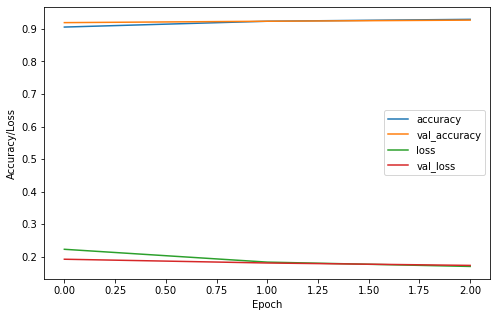

time: 290 ms


In [28]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 5))

plt.plot(epochs_range,train_history.history['accuracy'], label='accuracy')
plt.plot(epochs_range,train_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(epochs_range,train_history.history['loss'], label='loss')
plt.plot(epochs_range,train_history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='center right')

In [29]:
loss,accuracy = model.evaluate(test,verbose=1)
print(loss,accuracy)

39/39 [==============================] - 13s 340ms/step - loss: 0.1864 - accuracy: 0.9237
0.18636451012048966 0.92374945
time: 13.6 s


Stage 2

In [30]:
# n_steps = x_valid.shape[0] // BATCH_SIZE
# train_history_2 = model.fit(
#     valid_dataset.repeat(),
#     steps_per_epoch=n_steps,
#     epochs=EPOCHS*2
# )

time: 480 µs


Creating submission file

In [31]:
sub1 = pd.read_csv(data_path + 'sample_submission.csv')
sub1['toxic'] = model.predict(final_test_data, verbose=1)

499/499 [==============================] - 61s 123ms/step
time: 1min 1s


In [32]:
sub1.to_csv('submission.csv', index=False)
sub1.head(15)

,id,toxic
0,0,0.001416
1,1,0.000421
2,2,0.139870
3,3,0.000467
4,4,0.000451
5,5,0.569897
6,6,0.000736
7,7,0.010802
8,8,0.054721
9,9,0.011422


time: 566 ms


# THE END